In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import warnings
from matplotlib import rcParams

warnings.filterwarnings("ignore")

rcParams["figure.figsize"] = (4, 4)

# Integration with slide level-labels

In this tutorial we will demonstrate how to integrate whole slide images (WSIs) with slide-level labels and derive quantitative scores for each slide via top-K scoring.

We will also demonstrate how to run tasks in a distributed fashion using dask.

For this, we will be using a pre-processed dataset of artery tissue from GTEx, whihc contains healthy and calcified samples.

In [2]:
import pooch
import pandas as pd

table = pooch.retrieve(
    url="https://lazyslide.blob.core.windows.net/lazyslide-data/GTEx_artery_dataset.csv.gz",
    fname="GTEx_artery_dataset.csv.gz",
    path=".",
    known_hash=None,
)

dataset = pd.read_csv(table)
dataset.head()

,Tissue Sample Id,Sex,Age Bracket,Pathology Categories
0,GTEX-111YS-2226,male,60-69,calcification
1,GTEX-11GSP-2926,female,60-69,calcification
2,GTEX-11LCK-1426,male,30-39,clean_specimens
3,GTEX-11ONC-2726,male,60-69,calcification
4,GTEX-12126-0726,male,20-29,clean_specimens


## Distributed processing with dask

When running GPU-intensive works like feature extraction for multiple WSIs, we recommanded to run one task on one GPU every time. To accelarate the processing speed, either distributed across multiple GPU cards or multiple machines.

Here, we showcase how to parallel the jobs with dask on a SLURM cluster. 

For different hardward availabilities, alternatives are:
1. [dask-jobqueue](https://jobqueue.dask.org/en/latest/): For PBS, Slurm, MOAB, SGE, LSF, and HTCondor.
2. [coiled](https://docs.coiled.io/user_guide/index.html): AWS, GCP, Azure etc.
3. [dask-cuda](https://docs.rapids.ai/api/dask-cuda/nightly/quickstart/): If you have multiple GPU cards locally.

In [ ]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = SLURMCluster(
    queue="gpu",
    cores=8,
    processes=1,
    memory="20 GB",
    job_extra_directives=["-q gpu", "--gres=gpu:h100pcie:1", "--time=02:00:00"],
    worker_extra_args=["--resources GPU=1"],
    log_directory="./dask-logs",
)

client = Client(cluster)
cluster.scale(3)

In [36]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.110.81.4:8787/status,
Dashboard: http://10.110.81.4:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.110.81.4:36441,Workers: 0
Dashboard: http://10.110.81.4:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Let's define the task that we want to do for each slide.

In [37]:
from wsidata import open_wsi
import lazyslide as zs
import numpy as np

In [38]:
terms = ["calcification", "atherosclerosis"]


def wsi_feature_extraction(slide):
    s = pooch.retrieve(
        url=f"https://brd.nci.nih.gov/brd/imagedownload/{slide}",
        fname=f"{slide}.svs",
        path="gtex_artery_slides",
        known_hash=None,
    )
    wsi = open_wsi(s)
    zs.pp.find_tissues(wsi)
    zs.pp.tile_tissues(wsi, 256, mpp=0.5, background_fraction=0.5)

    # uni2 features
    zs.tl.feature_extraction(wsi, "uni2")
    zs.tl.feature_aggregation(wsi, "uni2")

    # conch feature
    zs.tl.feature_extraction(wsi, "conch", pbar=False)
    embed = zs.tl.text_embedding(terms)
    zs.tl.text_image_similarity(wsi, embed, "conch")
    wsi.write()

    # score the slide with Top-K max pooling
    scores = zs.metrics.topk_scores(wsi["conch_tiles_text_similarity"], k=100)

    return scores

In [39]:
futures = [
    client.submit(wsi_feature_extraction, slide, resources={"GPU": 1})
    for slide in dataset["Tissue Sample Id"]
]

If you want to monitor the process, you can either go to the dask dashboard or use a simple progress bar

In [ ]:
from dask.distributed import as_completed
from tqdm.auto import tqdm

for _ in tqdm(as_completed(futures), total=len(futures)):
    pass

In [41]:
slide_scores = pd.DataFrame(
    np.vstack([f.result() for f in futures]),
    columns=terms,
    index=dataset["Tissue Sample Id"],
)
slide_scores.to_csv("slide_scores.csv")

## Examination of Top-K scoring by text query

<Axes: xlabel='Pathology Categories', ylabel='calcification'>

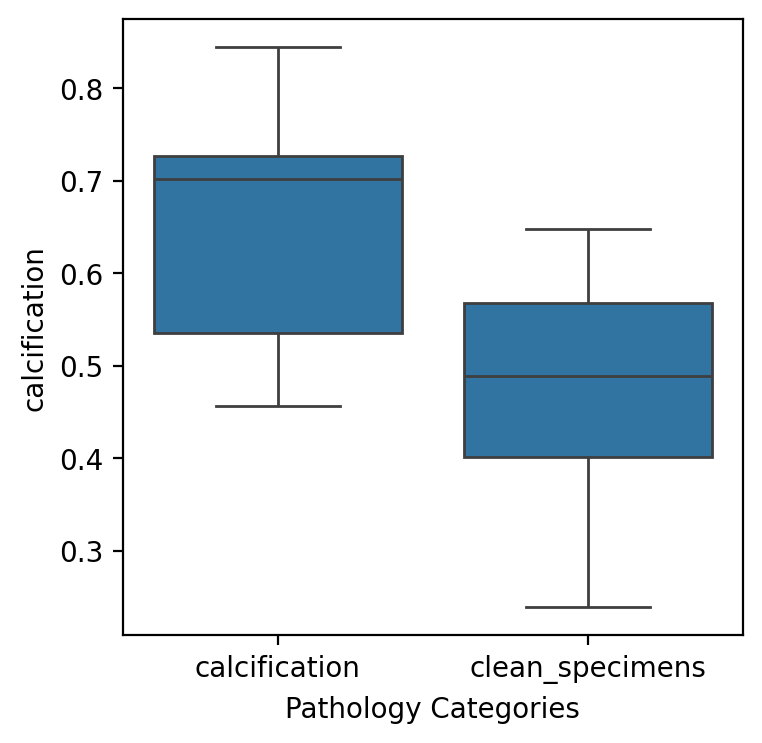

In [42]:
import seaborn as sns

sns.boxplot(
    data=slide_scores.join(dataset.set_index("Tissue Sample Id")),
    x="Pathology Categories",
    y="calcification",
)

In [87]:
client.shutdown()

## Slide aggregation

In [43]:
from wsidata import agg_wsi

dataset["slide"] = [f"gtex_artery_slides/{s}.svs" for s in dataset["Tissue Sample Id"]]
agg_data = agg_wsi(dataset, "uni2", wsi_col="slide", agg_key="agg_slide")
agg_data.obs = agg_data.obs.merge(slide_scores, on="Tissue Sample Id").set_index(
    "Tissue Sample Id"
)
agg_data

AnnData object with n_obs × n_vars = 45 × 1536
    obs: 'Sex', 'Age Bracket', 'Pathology Categories', 'slide', 'calcification', 'atherosclerosis'

In [44]:
agg_data.write_h5ad("agg_uni2_features.h5ad")